# **Problem Statement:** To predict the sales for products across stores of retail chain

#**Description:** There will be wide range of products that will be available in a retail super market such as perishables, fastmoving consumer goods, food items and others.
 

1. Predicting the products accurately helps in Meeting the demand there by improving the revenue .
2. Managing the expensive stocks will become easy there by cutting the loses.
3. Effective management of overall stocks of wide variety.

# Importing the required libraries

In [0]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from sklearn.metrics import mean_squared_error


Setting the google colab environment

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Reading all the given datasets 

In [0]:
data = pd.read_csv("/content/drive/My Drive/MITH/train_data.csv")
product_price = pd.read_csv("/content/drive/My Drive/MITH/product_prices-1585196839158.csv")
date_to_week = pd.read_csv("/content/drive/My Drive/MITH/date_to_week_id_map-1585196862691.csv")
unseen_data = pd.read_csv("/content/drive/My Drive/MITH/test_data-1585196922695.csv") 

# 1. Exploring the datasets given

In [6]:
data.shape

(395000, 7)

In [7]:
data.describe()

,product_identifier,department_identifier,outlet,sales
count,395000.000000,395000.000000,395000.000000,395000.000000
mean,1509.960000,24.460000,211.200000,1.228919
std,809.799518,6.337863,91.161291,3.595266
min,74.000000,11.000000,111.000000,0.000000
25%,926.000000,21.000000,113.000000,0.000000
50%,1325.000000,22.000000,221.500000,0.000000
75%,1753.000000,31.000000,331.000000,1.000000
max,3021.000000,33.000000,333.000000,293.000000


In [8]:
data.head()

,date,product_identifier,department_identifier,category_of_product,outlet,state,sales
0,2012-01-01,74,11,others,111,Maharashtra,0
1,2012-01-01,337,11,others,111,Maharashtra,1
2,2012-01-01,423,12,others,111,Maharashtra,0
3,2012-01-01,432,12,others,111,Maharashtra,0
4,2012-01-01,581,21,fast_moving_consumer_goods,111,Maharashtra,0


In [9]:
product_price.shape

(59000, 4)

In [10]:
product_price.head()

,outlet,product_identifier,week_id,sell_price
0,111,74,49,2.94
1,111,74,50,2.94
2,111,74,51,2.94
3,111,74,52,2.94
4,111,74,53,2.94


In [11]:
date_to_week.shape

(821, 2)

In [12]:
date_to_week.head()

,date,week_id
0,2012-01-01,49
1,2012-01-02,49
2,2012-01-03,49
3,2012-01-04,49
4,2012-01-05,49


In [13]:
date_to_week.week_id.nunique()

118

# 1.2
## The Train data given contains the information about products that have been sold in different outlets and also the date at which they are sold.
## The Product prices dataset contains the price of the product at different week.
## The date to week data set contains the mapping between the dates and the separated week ids (which are not the week number in a year but i have assumed these week ids as the week after the retail store has started)

# 1.3 Merging the data sets train data and date to week mappings

In [0]:
data2 = pd.merge(data,date_to_week,on="date",how="left") #left merge on date, date is common in both datasets, we get week ids for respective dates in to the new dataset
unseen_data2 = pd.merge(unseen_data,date_to_week,on="date",how="left") 

In [15]:
data2.shape # same shape as the train dataset with additional week column

(395000, 8)

In [16]:
data2.head()

,date,product_identifier,department_identifier,category_of_product,outlet,state,sales,week_id
0,2012-01-01,74,11,others,111,Maharashtra,0,49
1,2012-01-01,337,11,others,111,Maharashtra,1,49
2,2012-01-01,423,12,others,111,Maharashtra,0,49
3,2012-01-01,432,12,others,111,Maharashtra,0,49
4,2012-01-01,581,21,fast_moving_consumer_goods,111,Maharashtra,0,49


# 1.5 Merging the train data and product prices for the respective week.
  ##   Merging based on three columns as the price may depend on the product, outlet and week.

In [0]:
data3 = pd.merge(data2,product_price,right_on=["product_identifier","outlet","week_id"],left_on=["product_identifier","outlet","week_id"],how="left") 
unseen_data3= pd.merge(unseen_data2,product_price,right_on=["product_identifier","outlet","week_id"],left_on=["product_identifier","outlet","week_id"],how="left")

In [18]:
data3.head()

,date,product_identifier,department_identifier,category_of_product,outlet,state,sales,week_id,sell_price
0,2012-01-01,74,11,others,111,Maharashtra,0,49,2.94
1,2012-01-01,337,11,others,111,Maharashtra,1,49,7.44
2,2012-01-01,423,12,others,111,Maharashtra,0,49,0.97
3,2012-01-01,432,12,others,111,Maharashtra,0,49,4.97
4,2012-01-01,581,21,fast_moving_consumer_goods,111,Maharashtra,0,49,4.88


In [19]:
data3.tail()

,date,product_identifier,department_identifier,category_of_product,outlet,state,sales,week_id,sell_price
394995,2014-02-28,2932,33,drinks_and_food,333,Kerala,2,161,2.78
394996,2014-02-28,2935,33,drinks_and_food,333,Kerala,8,161,0.20
394997,2014-02-28,3004,33,drinks_and_food,333,Kerala,0,161,2.50
394998,2014-02-28,3008,33,drinks_and_food,333,Kerala,0,161,1.98
394999,2014-02-28,3021,33,drinks_and_food,333,Kerala,0,161,2.08


# 1.6 Deep dive into the data

In [0]:
def inspect_data(data):
    return pd.DataFrame({"Data Type":data.dtypes,"No of Levels":data.apply(lambda x: x.nunique(),axis=0),"% of Unique Levels":data.apply(lambda x: 100*x.nunique()/len(x),axis=0), "Levels":data.apply(lambda x: str(x.unique()),axis=0)}).sort_values("% of Unique Levels", ascending=False)


In [21]:
inspect_data(data3)

,Data Type,No of Levels,% of Unique Levels,Levels
date,object,790,0.200000,['2012-01-01' '2012-01-02' '2012-01-03' '2012-...
sales,int64,126,0.031899,[0 1 3 2 9 5 8 18 12 28 4 6 27 7 10 47 13 11 3...
week_id,int64,113,0.028608,[49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 ...
sell_price,float64,107,0.027089,[2.94 7.44 0.97 4.97 4.88 2.84 6.97 3.97 4.47 ...
product_identifier,int64,50,0.012658,[74 337 423 432 581 611 631 659 743 797 868 90...
outlet,int64,10,0.002532,[111 112 113 114 221 222 223 331 332 333]
department_identifier,int64,6,0.001519,[11 12 21 22 31 33]
category_of_product,object,3,0.000759,['others' 'fast_moving_consumer_goods' 'drinks...
state,object,3,0.000759,['Maharashtra' 'Telangana' 'Kerala']


# 1. We have 790 days sales data(113 weeks).
# 2. The data has 50 different products which belong to 6 different departments that belong to 3 different categories.
# 3. sales for 3 states  are present.
# 4. Data contains sales information for 10 outlets.
  

# Converting the date format for extracting information based on the date

In [22]:
data3.dtypes

date                      object
product_identifier         int64
department_identifier      int64
category_of_product       object
outlet                     int64
state                     object
sales                      int64
week_id                    int64
sell_price               float64
dtype: object

In [0]:
data3["date"]=pd.to_datetime(data3.date)
unseen_data3["date"]=pd.to_datetime(unseen_data.date)

# Checking if there are any null values in the data

In [24]:
data3.isnull().sum()

date                     0
product_identifier       0
department_identifier    0
category_of_product      0
outlet                   0
state                    0
sales                    0
week_id                  0
sell_price               0
dtype: int64

### we have no missing values

# 2. Exploratory data analysis using Visualizations


# 2.1 Sales vs Different products

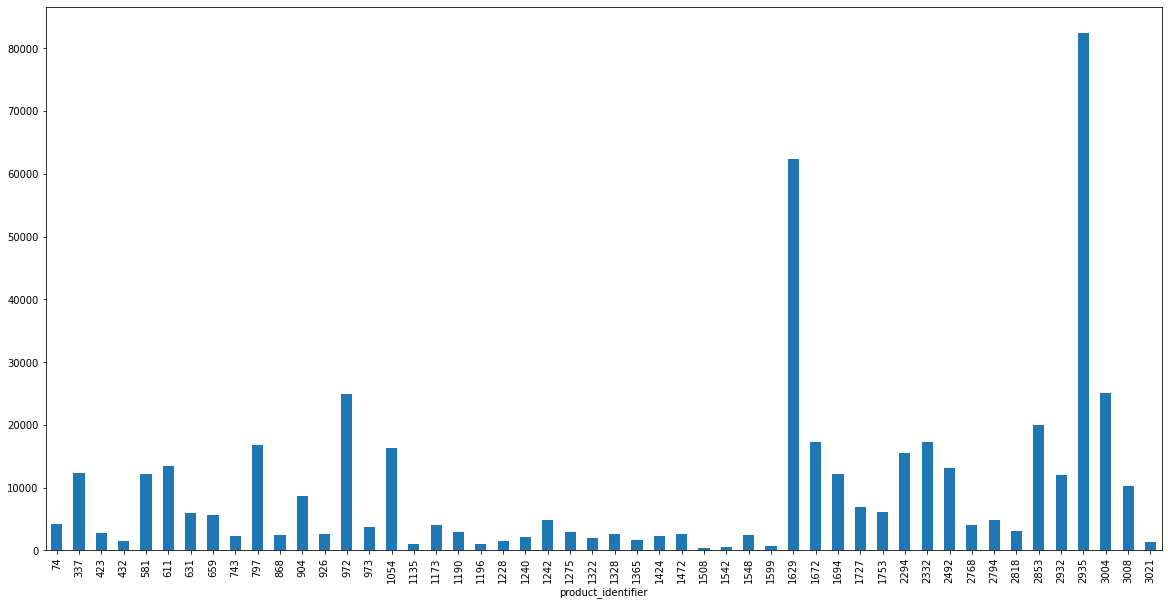

In [25]:
plt.figure(figsize=(20,10))
data3.groupby(["product_identifier"])["sales"].sum().plot(kind="bar")

The above plot gives more information about the prodcuts that are sold very often 

# 2.2 States vs Sales

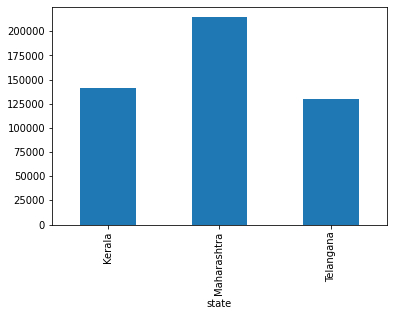

In [26]:
#sales per state
data3.groupby("state")["sales"].sum().plot(kind="bar")

The stores in Maharasta has more sales followed by Kerala and then Telangana. 
Note : Maharastra has 4 outlets, where as kerala and Telangana has 3 outlets each.

# 2.3 Different categories and sales

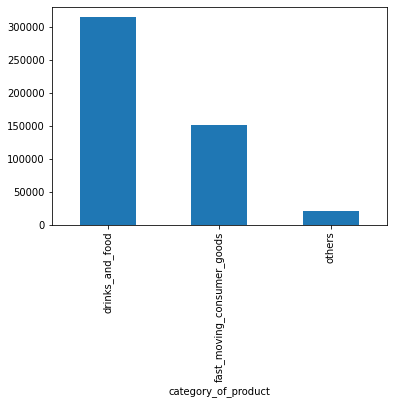

In [27]:
#sales per category
data3.groupby("category_of_product")["sales"].sum().plot(kind="bar")

# 2.4 Sales vs Outlets

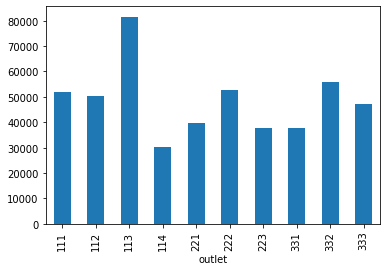

In [28]:
# sales per outlet
data3.groupby("outlet")["sales"].sum().plot(kind="bar")

# 2.5 Manipulating the dates to get more information on sales down the timeline

In [0]:
data3["year"]= data3.date.dt.year
data3["month"]=data3.date.dt.month
data3["weekday"]=data3.date.dt.weekday_name
data3["day"]=data3.date.dt.day

unseen_data3["year"]= unseen_data3.date.dt.year
unseen_data3["month"]=unseen_data3.date.dt.month
unseen_data3["weekday"]=unseen_data3.date.dt.weekday_name
unseen_data3["day"]=unseen_data3.date.dt.day


In [30]:
data3.head()

,date,product_identifier,department_identifier,category_of_product,outlet,state,sales,week_id,sell_price,year,month,weekday,day
0,2012-01-01,74,11,others,111,Maharashtra,0,49,2.94,2012,1,Sunday,1
1,2012-01-01,337,11,others,111,Maharashtra,1,49,7.44,2012,1,Sunday,1
2,2012-01-01,423,12,others,111,Maharashtra,0,49,0.97,2012,1,Sunday,1
3,2012-01-01,432,12,others,111,Maharashtra,0,49,4.97,2012,1,Sunday,1
4,2012-01-01,581,21,fast_moving_consumer_goods,111,Maharashtra,0,49,4.88,2012,1,Sunday,1


# 2.6 Weekday vs Sales

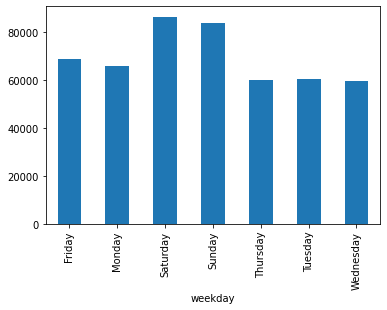

In [31]:
data3.groupby(["weekday"])["sales"].sum().plot(kind="bar")

we can see there are more sales happening in the weekends, so the day plays an importnant role in determining the sales. We can create a new column that specifies a particular day as weekday or weekend

# 2.7 Months vs Sales

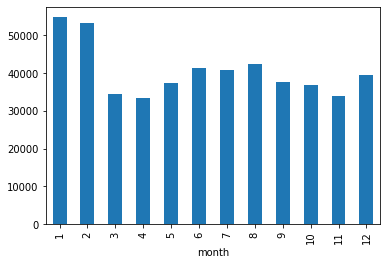

In [32]:
data3.groupby(["month"])["sales"].sum().plot(kind="bar")

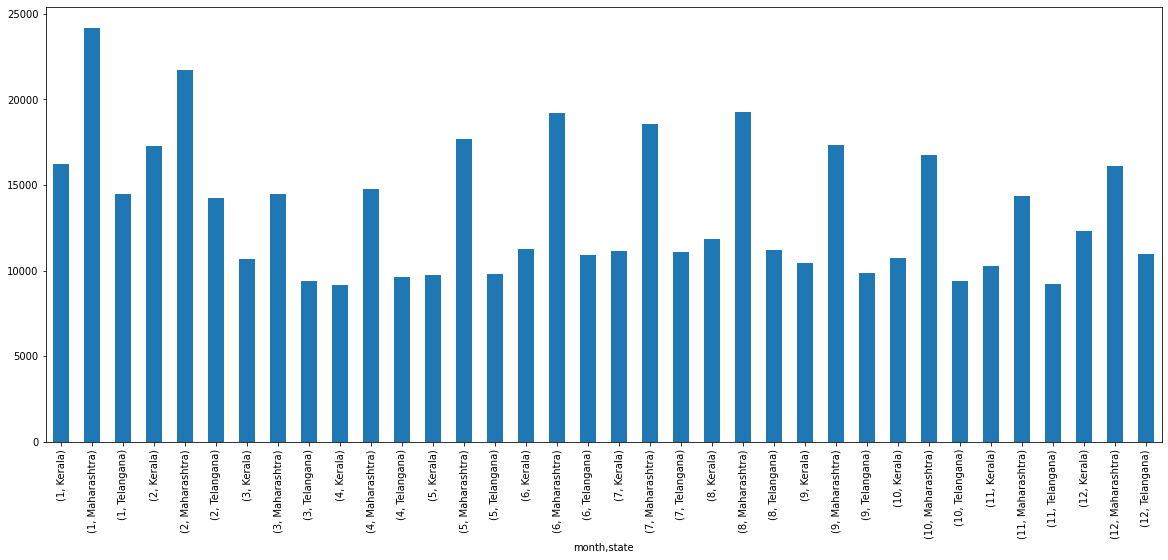

In [33]:
plt.figure(figsize=(20,8))
data3.groupby(["month","state"])["sales"].sum().plot(kind="bar")

As we have saturday and sunday having more sales, so it would be helpful if we can create a feature saying weekday and weekend.


# 3. Feature Engineering

In [34]:
data3["splday"] = "Weekday"
unseen_data3["splday"]="Weekday"
unseen_data3.head()

,id,date,product_identifier,department_identifier,category_of_product,outlet,state,week_id,sell_price,year,month,weekday,day,splday
0,1,2014-03-01,74,11,others,111,Maharashtra,162,3.43,2014,3,Saturday,1,Weekday
1,2,2014-03-01,337,11,others,111,Maharashtra,162,7.78,2014,3,Saturday,1,Weekday
2,3,2014-03-01,423,12,others,111,Maharashtra,162,0.97,2014,3,Saturday,1,Weekday
3,4,2014-03-01,432,12,others,111,Maharashtra,162,4.97,2014,3,Saturday,1,Weekday
4,5,2014-03-01,581,21,fast_moving_consumer_goods,111,Maharashtra,162,4.88,2014,3,Saturday,1,Weekday


In [35]:
data3["splday"][(data3.weekday=="Sunday") | (data3.weekday=="Saturday")] = "Weekend"
unseen_data3["splday"][(unseen_data3.weekday=="Sunday") | (unseen_data3.weekday=="Saturday")] = "Weekend"
unseen_data3.head()

,id,date,product_identifier,department_identifier,category_of_product,outlet,state,week_id,sell_price,year,month,weekday,day,splday
0,1,2014-03-01,74,11,others,111,Maharashtra,162,3.43,2014,3,Saturday,1,Weekend
1,2,2014-03-01,337,11,others,111,Maharashtra,162,7.78,2014,3,Saturday,1,Weekend
2,3,2014-03-01,423,12,others,111,Maharashtra,162,0.97,2014,3,Saturday,1,Weekend
3,4,2014-03-01,432,12,others,111,Maharashtra,162,4.97,2014,3,Saturday,1,Weekend
4,5,2014-03-01,581,21,fast_moving_consumer_goods,111,Maharashtra,162,4.88,2014,3,Saturday,1,Weekend


#3.2 Feature selection

The "id" feature from the unseen data can be removed as is doesn't help in our predictions


In [0]:
unseen_data3.drop(columns="id",inplace=True)

The date feature can also be removed from both the Train and unseen data sets as all the required features where engineering from date, but keeping the date feature in train because in future i have used the date feature for splitting the train and validation data. So, i will only remove the date feature from useen data for now.

In [0]:
unseen_data3.drop(columns="date",inplace=True)

# checking if there is another seasonality

In [0]:
import statsmodels.api as sm

In [0]:
dp = data3.groupby(["date"])["sales"].sum()

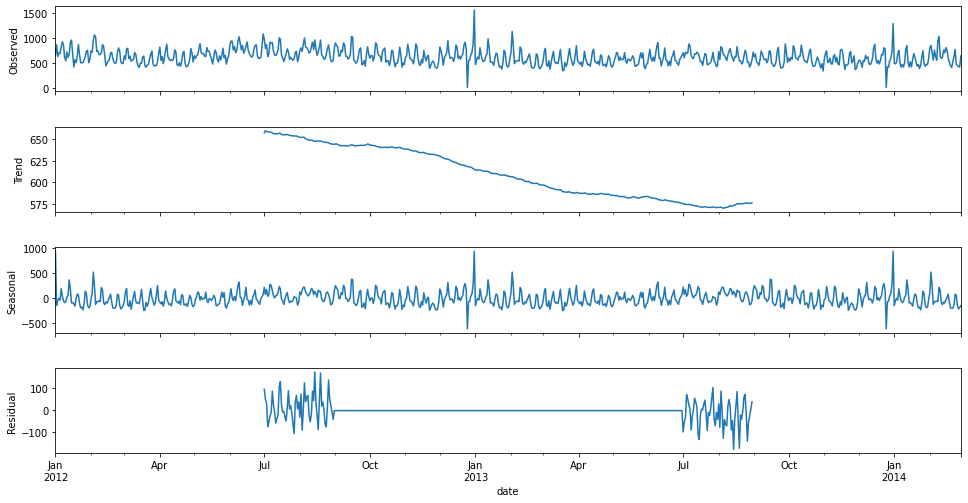

In [39]:
res = sm.tsa.seasonal_decompose(dp,freq=365)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
plt.show()

From the plot we can see that there is some seasonality in the month of december at the end for two years.

# Checking Monthly seasonality

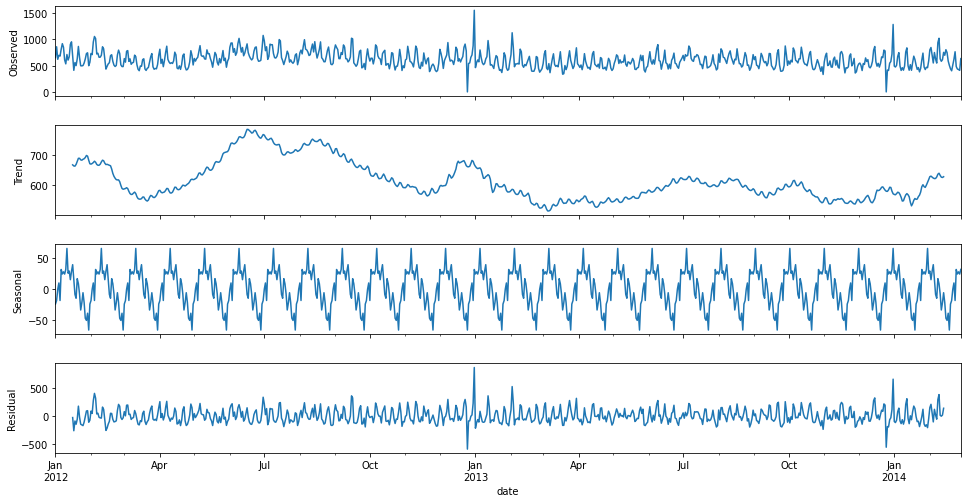

In [40]:
res = sm.tsa.seasonal_decompose(dp,freq=30)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
plt.show()

We can see that there exist seasonality in every month where there are hike in sales at the starting of the month and low sales at the end of the month

# Randomly checking seasonality in a particular to get the insight on which days of the month there are huge hikes in sales and lows in sales

In [0]:
start_date = "2012-1-1"
end_date = "2012-1-31"

after_start_date = data3["date"] >= start_date
before_end_date = data3["date"] <= end_date

jan12 = data3[after_start_date & before_end_date]
jan12d = jan12.groupby("date")["sales"].sum()

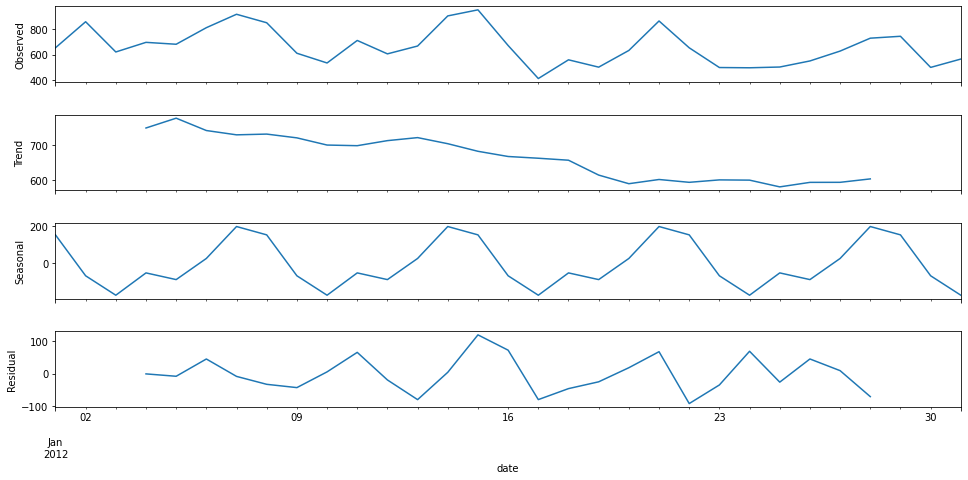

In [42]:
res = sm.tsa.seasonal_decompose(jan12d)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
plt.show()

In [0]:
start_date = "2012-12-1"
end_date = "2012-12-31"

after_start_date = data3["date"] >= start_date
before_end_date = data3["date"] <= end_date

dec12 = data3[after_start_date & before_end_date]
dec12d = dec12.groupby("date")["sales"].sum()

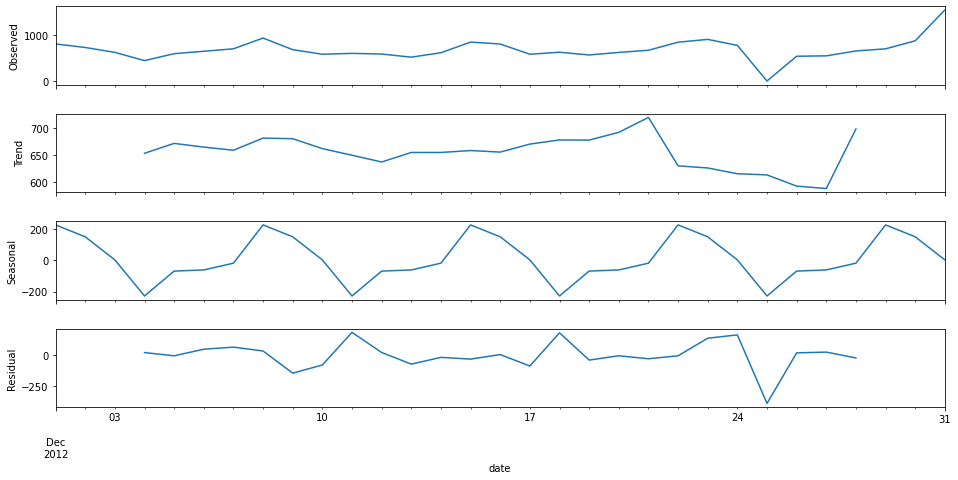

In [44]:
res = sm.tsa.seasonal_decompose(dec12d)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
plt.show()

we can see december has hike between 17 th and 24th which is actually a christmas week and another hike between 24th and 31st which is Newyear week, we can add this information in the dataset.

In [0]:
start_date = "2013-08-1"
end_date = "2013-08-31"

after_start_date = data3["date"] >= start_date
before_end_date = data3["date"] <= end_date

aug13 = data3[after_start_date & before_end_date]
aug13d = aug13.groupby("date")["sales"].sum()

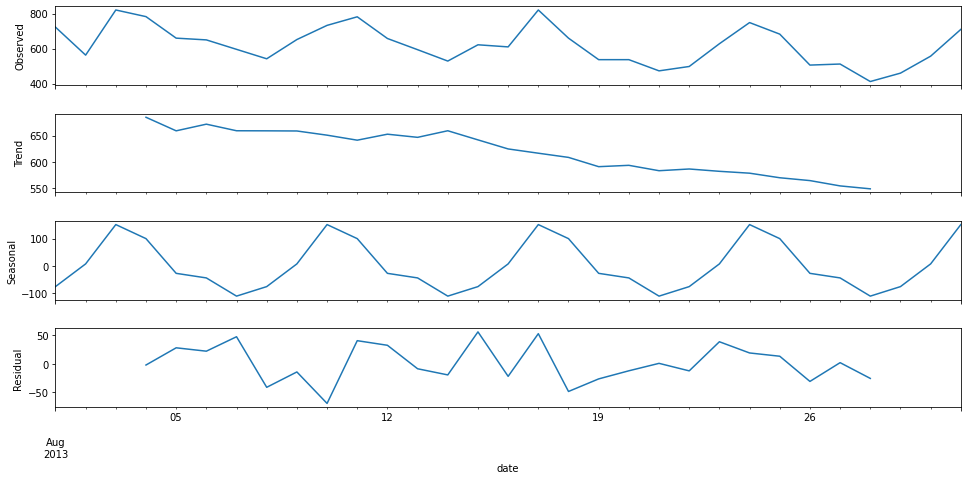

In [46]:
res = sm.tsa.seasonal_decompose(aug13d)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
plt.show()

In [0]:
start_date = "2013-10-1"
end_date = "2013-10-31"

after_start_date = data3["date"] >= start_date
before_end_date = data3["date"] <= end_date

oct13 = data3[after_start_date & before_end_date]
oct13d = oct13.groupby("date")["sales"].sum()

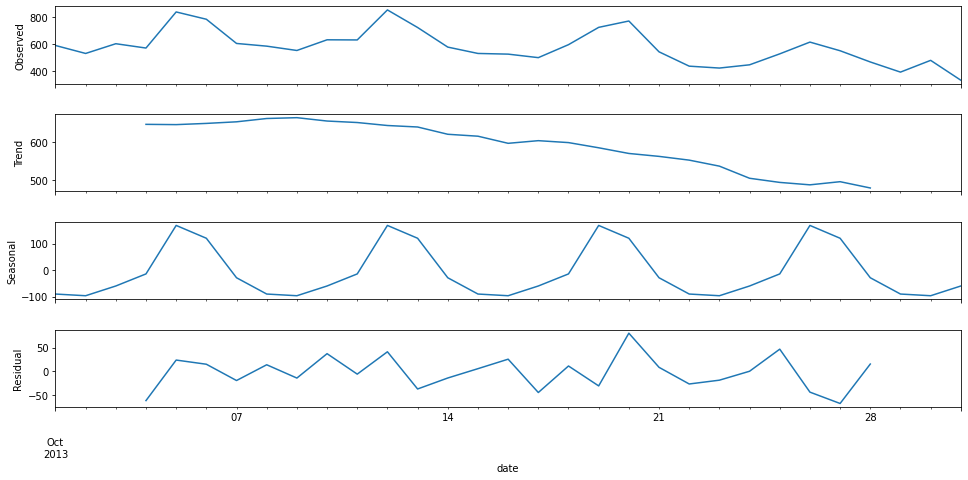

In [48]:
res = sm.tsa.seasonal_decompose(oct13d)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
plt.show()

# As we saw that the day of week plays an important in sales. In the same way there are some specific days which are national holidays in india that have hikes before or on those days.  Adding to the splday feature based on the above analysis.

In [0]:
data3["splday"][(data3.month==1) & (data3.day==1)] ="NewYear"
data3["splday"][(data3.month==8) & (data3.day==15)]="Holiday"
data3["splday"][(data3.month==1) & (data3.day==26)]="Holiday"
data3["splday"][(data3.month==12) & (data3.day>=18) & (data3.day<=25)]="Chriwk"
data3["splday"][(data3.month==12) & (data3.day>25) & (data3.day<=31)]="NWRwk"


In [50]:
data3[(data3.month==8) & (data3.day==15)]

,date,product_identifier,department_identifier,category_of_product,outlet,state,sales,week_id,sell_price,year,month,weekday,day,splday
113500,2012-08-15,74,11,others,111,Maharashtra,0,81,2.94,2012,8,Wednesday,15,Holiday
113501,2012-08-15,337,11,others,111,Maharashtra,1,81,7.78,2012,8,Wednesday,15,Holiday
113502,2012-08-15,423,12,others,111,Maharashtra,0,81,0.97,2012,8,Wednesday,15,Holiday
113503,2012-08-15,432,12,others,111,Maharashtra,0,81,4.97,2012,8,Wednesday,15,Holiday
113504,2012-08-15,581,21,fast_moving_consumer_goods,111,Maharashtra,5,81,4.88,2012,8,Wednesday,15,Holiday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296495,2013-08-15,2932,33,drinks_and_food,333,Kerala,6,133,2.98,2013,8,Thursday,15,Holiday
296496,2013-08-15,2935,33,drinks_and_food,333,Kerala,19,133,0.20,2013,8,Thursday,15,Holiday
296497,2013-08-15,3004,33,drinks_and_food,333,Kerala,2,133,2.68,2013,8,Thursday,15,Holiday
296498,2013-08-15,3008,33,drinks_and_food,333,Kerala,0,133,1.98,2013,8,Thursday,15,Holiday


# Checking if there exist similar pattern for same month of different year

In [51]:

march12=data3[(data3.month==3) & (data3.year==2012)] 
march13=data3[(data3.month==3) & (data3.year==2013)] 

marchd12 = march12.groupby(["date"])["sales"].sum()
marchd13 = march13.groupby(["date"])["sales"].sum()

marchd12


date
2012-03-01    635
2012-03-02    567
2012-03-03    776
2012-03-04    787
2012-03-05    581
2012-03-06    629
2012-03-07    526
2012-03-08    554
2012-03-09    563
2012-03-10    700
2012-03-11    672
2012-03-12    519
2012-03-13    431
2012-03-14    404
2012-03-15    494
2012-03-16    488
2012-03-17    616
2012-03-18    631
2012-03-19    438
2012-03-20    409
2012-03-21    449
2012-03-22    465
2012-03-23    564
2012-03-24    668
2012-03-25    730
2012-03-26    478
2012-03-27    431
2012-03-28    447
2012-03-29    440
2012-03-30    521
2012-03-31    697
Name: sales, dtype: int64

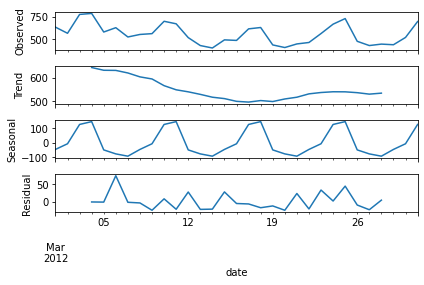

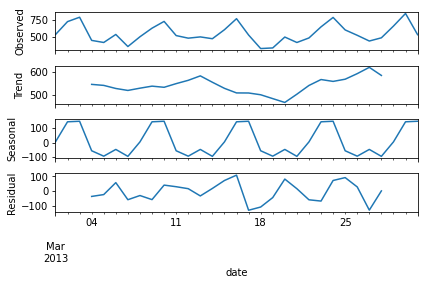

In [52]:
res1 = sm.tsa.seasonal_decompose(marchd12)
res2 = sm.tsa.seasonal_decompose(marchd13)
fig1 = res1.plot()
fig2 = res2.plot()


In [0]:
# checking if previous months have any influence on next month

In [0]:

feb12=data3[(data3.month==2) & (data3.year==2012)] 
feb13=data3[(data3.month==2) & (data3.year==2013)] 
feb14=data3[(data3.month==2) & (data3.year==2014)]
febd12 = feb12.groupby(["date"])["sales"].sum()
febd13 = feb13.groupby(["date"])["sales"].sum()
febd14 = feb14.groupby(["date"])["sales"].sum()

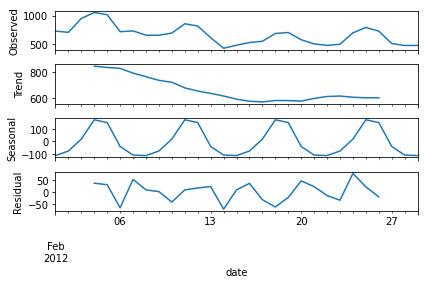

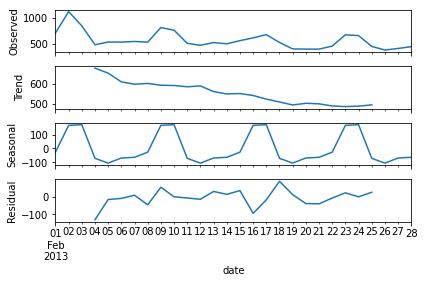

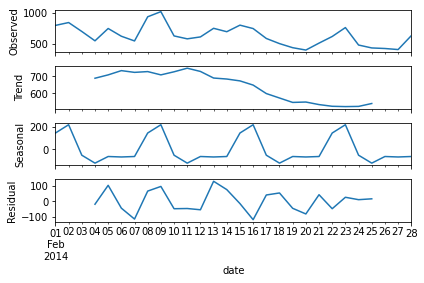

In [56]:
res1 = sm.tsa.seasonal_decompose(febd12)
res2 = sm.tsa.seasonal_decompose(febd13)
res3 = sm.tsa.seasonal_decompose(febd14)
fig1 = res1.plot()
fig2 = res2.plot()
fig3 = res3.plot()

# Checking the distibution of sales accross the months for a particular year 

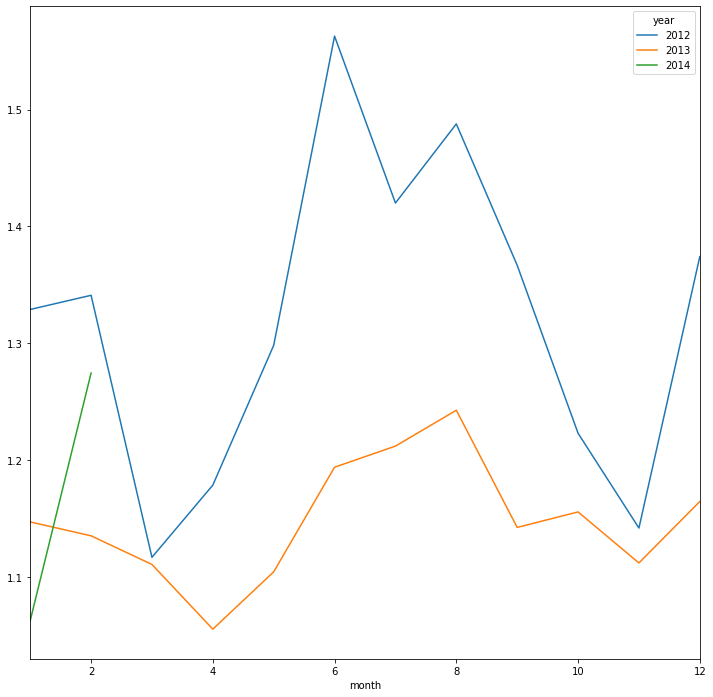

In [57]:
pivoted = pd.pivot_table(data3, values='sales', columns='year', index='month')
pivoted.plot(figsize=(12,12))


# Checking the distribution of sales across the states 

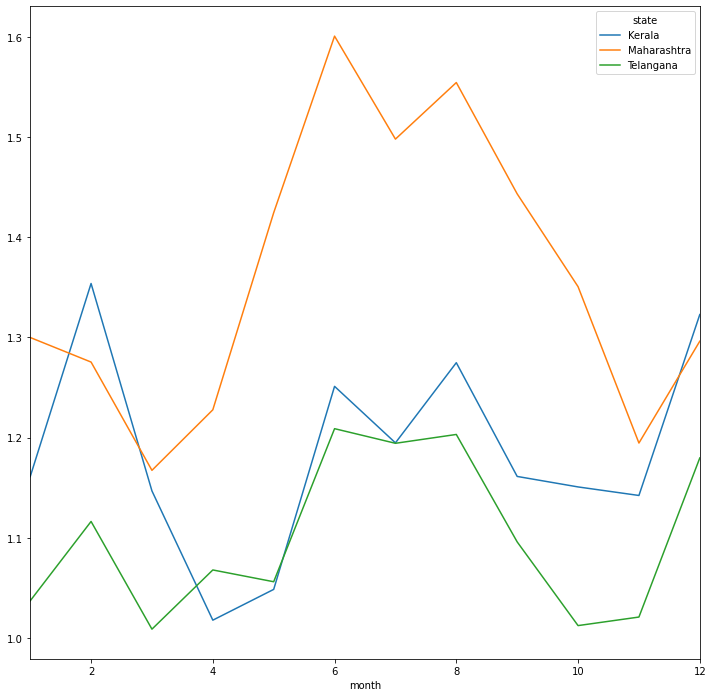

In [58]:
pivoted = pd.pivot_table(data3, values='sales', columns='state', index='month')
pivoted.plot(figsize=(12,12));


# Checking the distribution of sales across different outlets

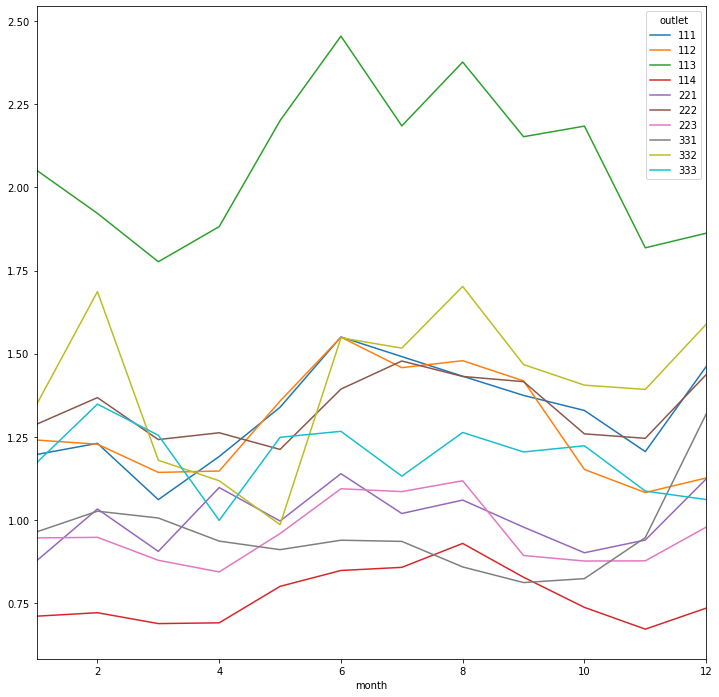

In [59]:
pivoted = pd.pivot_table(data3, values='sales', columns='outlet', index='month')
pivoted.plot(figsize=(12,12));

# 4. Encoding

In [68]:
lab_cols = [ 'category_of_product', 'state',"weekday","splday","product_identifier","department_identifier"]

X=data3.copy()
from sklearn.preprocessing import LabelEncoder
for i in range(0,len(X.columns)):
    j=X.columns[i]
    if(j in lab_cols):
        le = LabelEncoder()                  # converts the character array to numeric array. Assigns levels to unique labels.
        le.fit(X[j])
        X[j] = le.transform(X[j])
        X[j]=X[j].astype('category')

data4=X
data4.head()

,date,product_identifier,department_identifier,category_of_product,outlet,state,sales,week_id,sell_price,year,month,weekday,day,splday
0,2012-01-01,0,0,2,111,1,0,49,2.94,2012,1,3,1,3
1,2012-01-01,1,0,2,111,1,1,49,7.44,2012,1,3,1,3
2,2012-01-01,2,1,2,111,1,0,49,0.97,2012,1,3,1,3
3,2012-01-01,3,1,2,111,1,0,49,4.97,2012,1,3,1,3
4,2012-01-01,4,2,1,111,1,0,49,4.88,2012,1,3,1,3


In [69]:
lab_cols = [ 'category_of_product', 'state',"weekday","splday","product_identifier","department_identifier"]

X=unseen_data3.copy()
from sklearn.preprocessing import LabelEncoder
for i in range(0,len(X.columns)):
    j=X.columns[i]
    if(j in lab_cols):
        le = LabelEncoder()                  # converts the character array to numeric array. Assigns levels to unique labels.
        le.fit(X[j])
        X[j] = le.transform(X[j])
        X[j] =X[j].astype('category')

unseen_data4=X
unseen_data4.head()

,product_identifier,department_identifier,category_of_product,outlet,state,week_id,sell_price,year,month,weekday,day,splday
0,0,0,2,111,1,162,3.43,2014,3,2,1,1
1,1,0,2,111,1,162,7.78,2014,3,2,1,1
2,2,1,2,111,1,162,0.97,2014,3,2,1,1
3,3,1,2,111,1,162,4.97,2014,3,2,1,1
4,4,2,1,111,1,162,4.88,2014,3,2,1,1


# 5. Type casting the features

In [70]:
cat_cols = ["product_identifier","department_identifier","outlet","week_id","year","month","day"]
for i in cat_cols:
  data4[i]=data4[i].astype("category")
data4.dtypes

date                     datetime64[ns]
product_identifier             category
department_identifier          category
category_of_product            category
outlet                         category
state                          category
sales                             int64
week_id                        category
sell_price                      float64
year                           category
month                          category
weekday                        category
day                            category
splday                         category
dtype: object

In [71]:
cat_cols = ["product_identifier","department_identifier","outlet","week_id","year","month","day"]
for i in cat_cols:
  unseen_data4[i]=unseen_data4[i].astype("category")
unseen_data4.dtypes

product_identifier       category
department_identifier    category
category_of_product      category
outlet                   category
state                    category
week_id                  category
sell_price                float64
year                     category
month                    category
weekday                  category
day                      category
splday                   category
dtype: object

# 6. Scaling

In [0]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
data4.sell_price=ss.fit_transform(np.array(data4.sell_price).reshape(-1,1))
unseen_data4.sell_price=ss.fit_transform(np.array(unseen_data4.sell_price).reshape(-1,1))

In [73]:
data4.head()

,date,product_identifier,department_identifier,category_of_product,outlet,state,sales,week_id,sell_price,year,month,weekday,day,splday
0,2012-01-01,0,0,2,111,1,0,49,-0.528501,2012,1,3,1,3
1,2012-01-01,1,0,2,111,1,1,49,0.632958,2012,1,3,1,3
2,2012-01-01,2,1,2,111,1,0,49,-1.036961,2012,1,3,1,3
3,2012-01-01,3,1,2,111,1,0,49,-0.004554,2012,1,3,1,3
4,2012-01-01,4,2,1,111,1,0,49,-0.027783,2012,1,3,1,3


# 7. Train - Test split

In [0]:
train = data4[data4["date"]<'2013-11-01'] # Taking all the data before November 2013 as train data
test=data4[data4["date"]>='2013-11-01'] # Test data contains data after NOvmber 2013

X_train = train.drop(columns=["date","sales"]) #Train Features, dropping the date as we have met the need and sales data as it should contain only features
y_train = train["sales"] # Train Target
X_test = test.drop(columns=["date","sales"]) #Test Features
y_test = test["sales"] # TEst Target


In [102]:
X_train.tail()

,product_identifier,department_identifier,category_of_product,outlet,state,week_id,sell_price,year,month,weekday,day,splday
334995,45,5,0,333,0,144,-0.518177,2013,10,4,31,4
334996,46,5,0,333,0,144,-1.235700,2013,10,4,31,4
334997,47,5,0,333,0,144,-0.595607,2013,10,4,31,4
334998,48,5,0,333,0,144,-0.776278,2013,10,4,31,4
334999,49,5,0,333,0,144,-0.750468,2013,10,4,31,4


# 8. Bulding a linear Regression Model

In [103]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [0]:
train_pred=lr.predict(X_train)
test_pred=lr.predict(X_test)


In [105]:
print(np.sqrt (mean_squared_error(y_train,train_pred)))
print(np.sqrt(mean_squared_error(y_test,test_pred)))

3.3542860927297897
4.04669473572343


## Predicting on unseen data

In [0]:
unseen_predict=lr.predict(unseen_data4) # dropping the date and id features from unseen data

In [0]:
unseen_predict = pd.DataFrame(unseen_predict,columns=["sales"])


In [0]:
unseen_predict.to_csv("forecast_3592.csv",index = True)

In [0]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor


# 9.Building a Decision Tree

In [112]:
dt = DecisionTreeRegressor()
dt.fit(X_train,y_train)


DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [0]:
train_predict_dt = dt.predict(X_train)
test_predict_dt = dt.predict(X_test)

In [114]:
print(np.sqrt(mean_squared_error(y_test,test_predict_dt)))
print(np.sqrt(mean_squared_error(y_train,train_predict_dt)))

4.426708709639702
0.0


The model is overfit on training data. 

# 9.1 Tuning the parameters with grid search

In [115]:
dt_param_grid = { 'max_depth': [6,8,10,12], 
                 "min_samples_split": [2, 10, 20],"min_samples_leaf": [1, 5, 10],}
dt_paramtuned = GridSearchCV(DecisionTreeRegressor(), param_grid=dt_param_grid, cv=5)
dt_paramtuned.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse',
                                             max_depth=None, max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort='deprecated',
                                             random_state=None,
                                             splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': [6, 8, 10, 12],
                         'min_samples_leaf': [1, 5, 10],
                         'min_samples_split'

In [116]:
dt_paramtuned. best_params_

{'max_depth': 6, 'min_samples_leaf': 10, 'min_samples_split': 2}

In [117]:
dt_param_grid = { 'max_depth': [6,8,10], 
                 "min_samples_split": [5],"min_samples_leaf": [ 10],}
dt_paramtuned = GridSearchCV(DecisionTreeRegressor(), param_grid=dt_param_grid, cv=5)
dt_paramtuned.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse',
                                             max_depth=None, max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort='deprecated',
                                             random_state=None,
                                             splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': [6, 8, 10], 'min_samples_leaf': [10],
                         'min_samples_split': [5]},
             pre_dispatch='

In [118]:
dt_paramtuned. best_params_

{'max_depth': 6, 'min_samples_leaf': 10, 'min_samples_split': 5}

In [0]:
train_predict_dt_tuned = dt_paramtuned.predict(X_train)
test_predict_dt_tuned = dt_paramtuned.predict(X_test)

In [120]:
print(np.sqrt(mean_squared_error(y_test,test_predict_dt_tuned)))
print(np.sqrt(mean_squared_error(y_train,train_predict_dt_tuned)))

3.671190934281464
2.750358183331622


TUning the parameters has reduced the error on test slightly

# 10 Building a Random forest model

In [121]:
rf=RandomForestRegressor()
rf.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [0]:
train_predict_rf = rf.predict(X_train)
test_predict_rf = rf.predict(X_test)

In [123]:
print(np.sqrt(mean_squared_error(y_test,test_predict_rf)))
print(np.sqrt(mean_squared_error(y_train,train_predict_rf)))

3.3897561883809084
0.9524175783668054


In [0]:
 
unseen_predict_rf=rf.predict(unseen_data4)
unseen_predict_rf = pd.DataFrame(unseen_predict_rf,columns=["sales"])
unseen_predict_rf.to_csv("forecast4_3592.csv",index = True)

# 10.1 Tuning the parameters for Random forest 

In [0]:
rf_param_grid = { 'max_depth': [6,8,10,12], 
                 "min_samples_split": [2, 10, 20],"min_samples_leaf": [1, 5, 10]}
rf_paramtuned = GridSearchCV(RandomForestRegressor(), param_grid=rf_param_grid, cv=5)
rf_paramtuned.fit(X_train,y_train)

In [0]:
rf_paramtuned.best_params_

{'max_depth': 12, 'min_samples_leaf': 10, 'min_samples_split': 10}

In [0]:
train_predict_rf_tuned = rf_paramtuned.predict(X_train)
test_predict_rf_tuned = rf_paramtuned.predict(X_test)

In [0]:
print(np.sqrt(mean_squared_error(y_test,test_predict_rf_tuned)))
print(np.sqrt(mean_squared_error(y_train,train_predict_rf_tuned)))

3.4325938424376004
2.375296540202594


Predicting on unseendata

In [0]:
 
unseen_predict_rf=rf_paramtuned.predict(unseen_data4)
unseen_predict_rf = pd.DataFrame(unseen_predict_rf,columns=["sales"])
unseen_predict_rf.to_csv("forecast5_3592.csv",index = True)

# 11. Building AdaBoost Model

In [0]:
from sklearn.ensemble import AdaBoostRegressor

In [129]:
ab = AdaBoostRegressor()
ab.fit(X_train,y_train)

AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
                  n_estimators=50, random_state=None)

In [0]:
train_ab=ab.predict(X_train)
test_ab = ab.predict(X_test)

In [131]:
print(np.sqrt(mean_squared_error(y_train,train_ab)))
print(np.sqrt(mean_squared_error(y_test,test_ab)))

3.496554986683908
5.182428218122962


We have high values for train and test data, lets tune the hyper parameters

# 11.1 Tuning the parameters using grid *search*

In [0]:
ab_param_grid = { "n_estimators":[75,100], "learning_rate":[0.5,0.7],}
ab_paramtuned = GridSearchCV(AdaBoostRegressor(), param_grid=ab_param_grid, cv=5)
ab_paramtuned.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=AdaBoostRegressor(base_estimator=None, learning_rate=1.0,
                                         loss='linear', n_estimators=50,
                                         random_state=None),
             iid='deprecated', n_jobs=None,
             param_grid={'learning_rate': [0.5, 0.7],
                         'n_estimators': [75, 100]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [0]:
train_ab_tuned=ab_paramtuned.predict(X_train)
test_ab_tuned = ab_paramtuned.predict(X_test)

In [0]:
print(np.sqrt(mean_squared_error(y_train,train_ab_tuned)))
print(np.sqrt(mean_squared_error(y_test,test_ab_tuned)))

3.5922312055747545
5.744563044232988


# 12. Building a LGBMRegressor 

In [0]:
from lightgbm import LGBMRegressor

In [133]:
lg = LGBMRegressor()
lg.fit(X_train,y_train)


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [0]:
train_predict_lg = lg.predict(X_train)
test_predict_lg = lg.predict(X_test)

In [135]:
print(np.sqrt(mean_squared_error(y_train,train_predict_lg)))
print(np.sqrt(mean_squared_error(y_test,test_predict_lg)))

2.2391350170068263
3.5489968776069554


# Just tried training on the whole data and predicted on the useen data

In [ ]:
data10 = pd.concat([X_train,X_test])
data10.drop(columns="state",inplace=True)
data10y = pd.concat([y_train,y_test])

In [ ]:
lg.fit(data10,data10y)

In [ ]:
 unseen_predict_lg=lg.predict(unseen_data4.drop(columns="state")
unseen_predict_lg = pd.DataFrame(unseen_predict_lg,columns=["sales"])
unseen_predict_lg.to_csv("forecast7_3592.csv",index = True)

## **Overfitting**: The models are overfit on training data twice, i have managed to slighty reduce the test error by tuning the hyper parameters

# **Important Feature**:  I found the spldays feature(Engineered from date) as the important feature which gave me good predict for sales with low rmse. 